In [ ]:
# Generate a realistic synthetic dataset for a 12-month PD model
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

np.random.seed(7)

n = 20000  # rows

# 1) Application dates over ~3 years for time-based splits
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 12, 31)
days_range = (end_date - start_date).days
app_dates = [start_date + timedelta(days=int(x)) for x in np.random.randint(0, days_range+1, size=n)]

# 2) Categorical attributes
regions = ["Almaty", "Astana", "Shymkent", "East KZ", "West KZ", "North KZ", "South KZ", "Karaganda", "Atyrau"]
employment_statuses = ["salaried", "self_employed", "unemployed", "student", "retired"]
marital_statuses = ["single", "married", "divorced", "widowed"]
genders = ["F", "M"]
products = ["cash_loan", "pos_loan", "credit_card"]
channels = ["branch", "online", "partner_store"]

# 3) Base features
age = np.random.randint(20, 70, n)
gender = np.random.choice(genders, n, p=[0.55, 0.45])
marital_status = np.random.choice(marital_statuses, n, p=[0.45, 0.4, 0.12, 0.03])
region = np.random.choice(regions, n)
employment_status = np.random.choice(employment_statuses, n, p=[0.64, 0.16, 0.08, 0.04, 0.08])
job_tenure_months = np.clip(np.random.exponential(36, n).astype(int), 0, 360)
monthly_income = np.round(np.random.lognormal(mean=np.log(300_000), sigma=0.6, size=n), -3)  # KZT
has_mortgage = np.random.binomial(1, 0.25, n)
has_car_loan = np.random.binomial(1, 0.3, n)
num_active_loans = np.random.poisson(2, n)
bureau_score = np.clip(np.round(np.random.normal(650, 80, n)), 300, 900).astype(int)
external_score = np.clip(np.round(np.random.normal(0.5, 0.15, n), 3), 0.05, 0.95)  # 0..1
credit_limit = np.round(np.random.lognormal(mean=np.log(1_200_000), sigma=0.7, size=n), -3)  # KZT
product = np.random.choice(products, n, p=[0.5, 0.25, 0.25])
channel = np.random.choice(channels, n, p=[0.5, 0.3, 0.2])

# Behavior & delinquency features (past 12m before application)
avg_utilization = np.clip(np.random.beta(2, 4, n), 0, 0.99)
max_util_3m = np.maximum(avg_utilization, np.clip(avg_utilization + np.random.normal(0.1, 0.1, n), 0, 0.99))
delinq_12m_30dpd = np.random.poisson(0.4, n)
worst_dpd_12m = np.clip((np.random.geometric(p=0.3, size=n) - 1) * 15, 0, 120)  # 0, 15, 30, ..., 120
recent_hard_inquiries = np.random.poisson(0.6, n)

# Application features
requested_amount = np.round(np.random.lognormal(mean=np.log(800_000), sigma=0.7, size=n), -3)  # KZT
term_months = np.random.choice([6, 9, 12, 18, 24, 36], n, p=[0.06,0.08,0.3,0.2,0.2,0.16])
interest_rate = np.clip(np.random.normal(0.32, 0.07, n), 0.12, 0.55)  # nominal annual, rough

# Derived ratios
dti = np.clip(requested_amount / np.maximum(monthly_income * (term_months/12), 50_000), 0, 3.0)
limit_usage_ratio = np.clip(requested_amount / np.maximum(credit_limit, 50_000), 0, 2.0)

# 4) Macro seasoning (simulate rising risk in some months)
def month_macro(dt):
    # mildly worse during late 2023-mid 2024; better in early 2022
    if datetime(2023,9,1) <= dt <= datetime(2024,6,30):
        return 0.15
    if dt.year == 2022 and dt.month <= 6:
        return -0.12
    return 0.0

macro = np.array([month_macro(d) for d in app_dates])

# 5) True PD generator (logit linking typical risk drivers)
# Start with linear predictor
lin = (
    -3.0
    + 0.8 * dti
    + 1.2 * limit_usage_ratio
    + 0.015 * (70 - age)  # younger a bit riskier
    + 0.8 * (employment_status == "unemployed").astype(int)
    + 0.3 * (employment_status == "student").astype(int)
    + 0.4 * (marital_status == "single").astype(int)
    + 0.35 * avg_utilization
    + 0.6 * (max_util_3m > 0.85).astype(int)
    + 0.25 * recent_hard_inquiries
    + 0.15 * delinq_12m_30dpd
    + 0.012 * worst_dpd_12m
    - 0.004 * (bureau_score - 650)
    - 1.0 * has_mortgage
    - 0.5 * has_car_loan * (product == "credit_card").astype(int)
    + macro
)

# Product/channels adjustments
lin += np.where(product == "cash_loan", 0.25, 0.0)
lin += np.where(product == "pos_loan", -0.15, 0.0)
lin += np.where(channel == "online", 0.1, 0.0)
lin += np.where(channel == "partner_store", 0.05, 0.0)

# External score improving risk (non-linear)
lin += -1.4 * (external_score - 0.5)

# Convert to probability
pd_true = 1 / (1 + np.exp(-lin))

# 6) Realized default within 12 months (Bernoulli draw)
default_12m = np.random.binomial(1, pd_true)

# 7) Optional LGD/EAD for later profit modeling (rough simulators)
ead = np.where(product == "credit_card",
               credit_limit * np.clip(np.random.normal(0.6, 0.2, n), 0.1, 1.2),
               requested_amount)
lgd = np.clip(np.random.normal(0.55, 0.12, n), 0.2, 0.9)

# Assemble DataFrame
df = pd.DataFrame({
    "application_date": pd.to_datetime(app_dates),
    "age": age,
    "gender": gender,
    "marital_status": marital_status,
    "region": region,
    "employment_status": employment_status,
    "job_tenure_months": job_tenure_months,
    "monthly_income_kzt": monthly_income.astype(int),
    "has_mortgage": has_mortgage,
    "has_car_loan": has_car_loan,
    "num_active_loans": num_active_loans,
    "bureau_score": bureau_score,
    "external_score": external_score,
    "credit_limit_kzt": credit_limit.astype(int),
    "avg_utilization": np.round(avg_utilization, 3),
    "max_util_3m": np.round(max_util_3m, 3),
    "delinq_12m_30dpd": delinq_12m_30dpd,
    "worst_dpd_12m": worst_dpd_12m,
    "recent_hard_inquiries": recent_hard_inquiries,
    "product": product,
    "channel": channel,
    "requested_amount_kzt": requested_amount.astype(int),
    "term_months": term_months,
    "interest_rate_annual": np.round(interest_rate, 3),
    "dti": np.round(dti, 3),
    "limit_usage_ratio": np.round(limit_usage_ratio, 3),
    "EAD_kzt": ead.astype(int),
    "LGD": np.round(lgd, 3),
    "pd_true": np.round(pd_true, 4),
    "default_12m": default_12m,
})

# Shuffle to avoid any ordering
df = df.sample(frac=1.0, random_state=7).reset_index(drop=True)

# Quick quality checks
bad_rate = df["default_12m"].mean()
date_min, date_max = df["application_date"].min(), df["application_date"].max()

# Save
csv_path = "C:\\DISTR\\pd_12m_dataset.csv"
df.to_csv(csv_path, index=False)


bad_rate, date_min, date_max, csv_path

(np.float64(0.6332),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2024-12-31 00:00:00'),
 'C:\\DISTR\\pd_12m_dataset.csv')

In [ ]:
df_loaded = pd.read_csv(csv_path)

# Показываем первые строки
print(df_loaded.head())

  application_date  age gender marital_status     region employment_status  \
0       2022-01-29   38      F        widowed  Karaganda     self_employed   
1       2024-12-04   25      F         single   Shymkent           retired   
2       2022-10-11   62      F       divorced   North KZ          salaried   
3       2023-01-25   58      F         single    West KZ     self_employed   
4       2023-10-09   28      M         single   Shymkent          salaried   

   job_tenure_months  monthly_income_kzt  has_mortgage  has_car_loan  ...  \
0                 96              702000             0             0  ...   
1                  3              431000             0             1  ...   
2                 74              144000             0             0  ...   
3                 25              481000             0             0  ...   
4                130              261000             0             0  ...   

         channel  requested_amount_kzt  term_months  interest_rate_a

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, confusion_matrix, classification_report
import matplotlib.pyplot as plt

missing = df_loaded.isnull().sum()

# Выводим результат
print(missing)
print(df_loaded['age'].max())

# Шаг 2: Биннинг
df_loaded['Age_bin'] = pd.cut(df_loaded['age'], bins=[0, 35, 51, 70], labels=['0-35', '35-51', '51-70'])

# Шаг 3: Расчет WOE
total_good = (df_loaded['default_12m'] == 0).sum()
total_bad = (df_loaded['default_12m'] == 1).sum()
pd.set_option('display.max_rows', None)

woe_table = df_loaded.groupby('Age_bin')['default_12m'].agg([
    ('Count', 'count'),
    ('Bad', 'sum'),])
woe_table['Good'] = woe_table['Count'] - woe_table['Bad']
woe_table['Distr_Good'] = woe_table['Good'] / total_good
woe_table['Distr_Bad'] = woe_table['Bad'] / total_bad

woe_table['WOE'] = np.log((woe_table['Distr_Good'].replace(0, 0.5 / total_good)) /
                          (woe_table['Distr_Bad'].replace(0, 0.5 / total_bad)))
woe_table['IV'] = (woe_table['Distr_Good']-woe_table['Distr_Bad'])*woe_table['WOE']
# Шаг 4: Назначаем WOE значения обратно в датафрейм
woe_map = woe_table['WOE'].to_dict()
df_loaded['age'] = df_loaded['Age_bin'].map(woe_map)
IV=woe_table['IV'].sum()
print("\n=== Таблица с результатами ===")
print(woe_table)
print("\n=== Total IV ===")
print(IV)

application_date         0
age                      0
gender                   0
marital_status           0
region                   0
employment_status        0
job_tenure_months        0
monthly_income_kzt       0
has_mortgage             0
has_car_loan             0
num_active_loans         0
bureau_score             0
external_score           0
credit_limit_kzt         0
avg_utilization          0
max_util_3m              0
delinq_12m_30dpd         0
worst_dpd_12m            0
recent_hard_inquiries    0
product                  0
channel                  0
requested_amount_kzt     0
term_months              0
interest_rate_annual     0
dti                      0
limit_usage_ratio        0
EAD_kzt                  0
LGD                      0
pd_true                  0
default_12m              0
dtype: int64
69

=== Таблица с результатами ===
         Count   Bad  Good  Distr_Good  Distr_Bad       WOE            IV
Age_bin                                                             

/tmp/ipython-input-392533360.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_table = df_loaded.groupby('Age_bin')['default_12m'].agg([


In [ ]:
df_loaded['gender']=df_loaded['gender'].replace('F', '0')
df_loaded['gender']=df_loaded['gender'].replace('M', '1')
df_loaded['gender']=df_loaded['gender'].astype(int)
print(df_loaded['monthly_income_kzt'].min())
print(df_loaded['monthly_income_kzt'].max())
# df_loaded.head()
# Шаг 2: Биннинг
df_loaded['Income_bin'] = pd.cut(df_loaded['monthly_income_kzt'], bins=[20000, 250000, 450000, 3000000], labels=['20-250', '250-450', '450-3000'])

# Шаг 3: Расчет WOE
total_good = (df_loaded['default_12m'] == 0).sum()
total_bad = (df_loaded['default_12m'] == 1).sum()
pd.set_option('display.max_rows', None)

woe_table = df_loaded.groupby('Income_bin')['default_12m'].agg([
    ('Count', 'count'),
    ('Bad', 'sum'),])
woe_table['Good'] = woe_table['Count'] - woe_table['Bad']
woe_table['Distr_Good'] = woe_table['Good'] / total_good
woe_table['Distr_Bad'] = woe_table['Bad'] / total_bad

woe_table['WOE'] = np.log((woe_table['Distr_Good'].replace(0, 0.5 / total_good)) /
                          (woe_table['Distr_Bad'].replace(0, 0.5 / total_bad)))
woe_table['IV'] = (woe_table['Distr_Good']-woe_table['Distr_Bad'])*woe_table['WOE']
# Шаг 4: Назначаем WOE значения обратно в датафрейм
woe_map = woe_table['WOE'].to_dict()
df_loaded['monthly_income_kzt'] = df_loaded['Income_bin'].map(woe_map)
IV=woe_table['IV'].sum()
print("\n=== Таблица с результатами ===")
print(woe_table)
print("\n=== Total IV ===")
print(IV)

23000
2978000

=== Таблица с результатами ===
            Count   Bad  Good  Distr_Good  Distr_Bad       WOE        IV
Income_bin                                                              
20-250       7674  5490  2184    0.297710   0.433512 -0.375801  0.051035
250-450      7310  4505  2805    0.382361   0.355733  0.072185  0.001922
450-3000     5016  2669  2347    0.319929   0.210755  0.417404  0.045570

=== Total IV ===
0.09852650033226443


/tmp/ipython-input-1924407299.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_table = df_loaded.groupby('Income_bin')['default_12m'].agg([


In [ ]:
# marital_status
# Шаг 2: Биннинг


# ["single", "married", "divorced", "widowed"]
# Шаг 3: Расчет WOE
total_good = (df_loaded['default_12m'] == 0).sum()
total_bad = (df_loaded['default_12m'] == 1).sum()
pd.set_option('display.max_rows', None)

woe_table = df_loaded.groupby('marital_status')['default_12m'].agg([
    ('Count', 'count'),
    ('Bad', 'sum'),])
woe_table['Good'] = woe_table['Count'] - woe_table['Bad']
woe_table['Distr_Good'] = woe_table['Good'] / total_good
woe_table['Distr_Bad'] = woe_table['Bad'] / total_bad

woe_table['WOE'] = np.log((woe_table['Distr_Good'].replace(0, 0.5 / total_good)) /
                          (woe_table['Distr_Bad'].replace(0, 0.5 / total_bad)))
woe_table['IV'] = (woe_table['Distr_Good']-woe_table['Distr_Bad'])*woe_table['WOE']
# Шаг 4: Назначаем WOE значения обратно в датафрейм
woe_map = woe_table['WOE'].to_dict()
df_loaded['marital_status'] = df_loaded['marital_status'].map(woe_map)
IV=woe_table['IV'].sum()
print("\n=== Таблица с результатами ===")
print(woe_table)
print("\n=== Total IV ===")
print(IV)


=== Таблица с результатами ===
                Count   Bad  Good  Distr_Good  Distr_Bad       WOE        IV
marital_status                                                              
divorced         2428  1489   939    0.127999   0.117577  0.084925  0.000885
married          7895  4711  3184    0.434024   0.371999  0.154208  0.009565
single           9050  6086  2964    0.404035   0.480575 -0.173482  0.013278
widowed           627   378   249    0.033942   0.029848  0.128528  0.000526

=== Total IV ===
0.024254177884736366


In [ ]:
# region

# Шаг 3: Расчет WOE
total_good = (df_loaded['default_12m'] == 0).sum()
total_bad = (df_loaded['default_12m'] == 1).sum()
pd.set_option('display.max_rows', None)

woe_table = df_loaded.groupby('region')['default_12m'].agg([
    ('Count', 'count'),
    ('Bad', 'sum'),])
woe_table['Good'] = woe_table['Count'] - woe_table['Bad']
woe_table['Distr_Good'] = woe_table['Good'] / total_good
woe_table['Distr_Bad'] = woe_table['Bad'] / total_bad

woe_table['WOE'] = np.log((woe_table['Distr_Good'].replace(0, 0.5 / total_good)) /
                          (woe_table['Distr_Bad'].replace(0, 0.5 / total_bad)))
woe_table['IV'] = (woe_table['Distr_Good']-woe_table['Distr_Bad'])*woe_table['WOE']
# Шаг 4: Назначаем WOE значения обратно в датафрейм
woe_map = woe_table['WOE'].to_dict()
df_loaded['region'] = df_loaded['region'].map(woe_map)
IV=woe_table['IV'].sum()
print("\n=== Таблица с результатами ===")
print(woe_table)
print("\n=== Total IV ===")
print(IV)


=== Таблица с результатами ===
           Count   Bad  Good  Distr_Good  Distr_Bad       WOE            IV
region                                                                     
Almaty      2248  1419   829    0.113004   0.112050  0.008482  8.095765e-06
Astana      2265  1456   809    0.110278   0.114972 -0.041680  1.956235e-04
Atyrau      2210  1369   841    0.114640   0.108102  0.058725  3.839718e-04
East KZ     2277  1448   829    0.113004   0.114340 -0.011749  1.569055e-05
Karaganda   2232  1398   834    0.113686   0.110392  0.029405  9.686826e-05
North KZ    2198  1401   797    0.108642   0.110629 -0.018117  3.598529e-05
Shymkent    2285  1465   820    0.111778   0.115682 -0.034337  1.340746e-04
South KZ    2178  1375   803    0.109460   0.108575  0.008115  7.179653e-06
West KZ     2107  1333   774    0.105507   0.105259  0.002354  5.840305e-07

=== Total IV ===
0.0008780733568045204


In [ ]:
# Шаг 3: Расчет WOE
total_good = (df_loaded['default_12m'] == 0).sum()
total_bad = (df_loaded['default_12m'] == 1).sum()
pd.set_option('display.max_rows', None)

woe_table = df_loaded.groupby('employment_status')['default_12m'].agg([
    ('Count', 'count'),
    ('Bad', 'sum'),])
woe_table['Good'] = woe_table['Count'] - woe_table['Bad']
woe_table['Distr_Good'] = woe_table['Good'] / total_good
woe_table['Distr_Bad'] = woe_table['Bad'] / total_bad

woe_table['WOE'] = np.log((woe_table['Distr_Good'].replace(0, 0.5 / total_good)) /
                          (woe_table['Distr_Bad'].replace(0, 0.5 / total_bad)))
woe_table['IV'] = (woe_table['Distr_Good']-woe_table['Distr_Bad'])*woe_table['WOE']
# Шаг 4: Назначаем WOE значения обратно в датафрейм
woe_map = woe_table['WOE'].to_dict()
df_loaded['employment_status'] = df_loaded['employment_status'].map(woe_map)
IV=woe_table['IV'].sum()
print("\n=== Таблица с результатами ===")
print(woe_table)
print("\n=== Total IV ===")
print(IV)


=== Таблица с результатами ===
                   Count   Bad  Good  Distr_Good  Distr_Bad       WOE  \
employment_status                                                       
retired             1585   966   619    0.084378   0.076279  0.100911   
salaried           12820  7958  4862    0.662759   0.628395  0.053242   
self_employed       3080  1917  1163    0.158533   0.151374  0.046211   
student              826   547   279    0.038032   0.043193 -0.127267   
unemployed          1689  1276   413    0.056298   0.100758 -0.582068   

                         IV  
employment_status            
retired            0.000817  
salaried           0.001830  
self_employed      0.000331  
student            0.000657  
unemployed         0.025879  

=== Total IV ===
0.029513580794897725


In [ ]:
# products
# Шаг 3: Расчет WOE
total_good = (df_loaded['default_12m'] == 0).sum()
total_bad = (df_loaded['default_12m'] == 1).sum()
pd.set_option('display.max_rows', None)

woe_table = df_loaded.groupby('product')['default_12m'].agg([
    ('Count', 'count'),
    ('Bad', 'sum'),])
woe_table['Good'] = woe_table['Count'] - woe_table['Bad']
woe_table['Distr_Good'] = woe_table['Good'] / total_good
woe_table['Distr_Bad'] = woe_table['Bad'] / total_bad

woe_table['WOE'] = np.log((woe_table['Distr_Good'].replace(0, 0.5 / total_good)) /
                          (woe_table['Distr_Bad'].replace(0, 0.5 / total_bad)))
woe_table['IV'] = (woe_table['Distr_Good']-woe_table['Distr_Bad'])*woe_table['WOE']
# Шаг 4: Назначаем WOE значения обратно в датафрейм
woe_map = woe_table['WOE'].to_dict()
df_loaded['product'] = df_loaded['product'].map(woe_map)
IV=woe_table['IV'].sum()
print("\n=== Таблица с результатами ===")
print(woe_table)
print("\n=== Total IV ===")
print(IV)


=== Таблица с результатами ===
             Count   Bad  Good  Distr_Good  Distr_Bad       WOE        IV
product                                                                  
cash_loan    10019  6704  3315    0.451881   0.529375 -0.158277  0.012265
credit_card   5003  3041  1962    0.267448   0.240130  0.107748  0.002944
pos_loan      4978  2919  2059    0.280671   0.230496  0.196949  0.009882

=== Total IV ===
0.025090835798178113


In [ ]:
# channel
# Шаг 3: Расчет WOE
total_good = (df_loaded['default_12m'] == 0).sum()
total_bad = (df_loaded['default_12m'] == 1).sum()
pd.set_option('display.max_rows', None)

woe_table = df_loaded.groupby('channel')['default_12m'].agg([
    ('Count', 'count'),
    ('Bad', 'sum'),])
woe_table['Good'] = woe_table['Count'] - woe_table['Bad']
woe_table['Distr_Good'] = woe_table['Good'] / total_good
woe_table['Distr_Bad'] = woe_table['Bad'] / total_bad

woe_table['WOE'] = np.log((woe_table['Distr_Good'].replace(0, 0.5 / total_good)) /
                          (woe_table['Distr_Bad'].replace(0, 0.5 / total_bad)))
woe_table['IV'] = (woe_table['Distr_Good']-woe_table['Distr_Bad'])*woe_table['WOE']
# Шаг 4: Назначаем WOE значения обратно в датафрейм
woe_map = woe_table['WOE'].to_dict()
df_loaded['channel'] = df_loaded['channel'].map(woe_map)
IV=woe_table['IV'].sum()
print("\n=== Таблица с результатами ===")
print(woe_table)
print("\n=== Total IV ===")
print(IV)


=== Таблица с результатами ===
               Count   Bad  Good  Distr_Good  Distr_Bad       WOE        IV
channel                                                                    
branch         10067  6307  3760    0.512541   0.498026  0.028728  0.000417
online          5931  3820  2111    0.287759   0.301642 -0.047119  0.000654
partner_store   4002  2537  1465    0.199700   0.200332 -0.003157  0.000002

=== Total IV ===
0.001073162263580079


In [ ]:
df_loaded = df_loaded.drop(columns=['Age_bin','Income_bin'])
df_loaded.head()

,application_date,age,gender,marital_status,region,employment_status,job_tenure_months,monthly_income_kzt,has_mortgage,has_car_loan,...,channel,requested_amount_kzt,term_months,interest_rate_annual,dti,limit_usage_ratio,EAD_kzt,LGD,pd_true,default_12m
0,2022-01-29,0.000866,0,0.128528,0.029405,0.046211,96,0.417404,0,0,...,-0.003157,662000,24,0.263,0.472,0.421,662000,0.486,0.4146,0
1,2024-12-04,-0.165027,0,-0.173482,-0.034337,0.100911,3,0.072185,0,1,...,0.028728,923000,18,0.384,1.428,0.430,923000,0.616,0.4423,1
2,2022-10-11,0.139812,0,0.084925,-0.018117,0.053242,74,-0.375801,0,0,...,-0.047119,881000,24,0.332,3.000,0.788,881000,0.375,0.7448,1
3,2023-01-25,0.139812,0,-0.173482,0.002354,0.046211,25,0.417404,0,0,...,-0.047119,3528000,12,0.223,3.000,2.000,107458,0.512,0.9843,1
4,2023-10-09,-0.165027,1,-0.173482,-0.034337,0.053242,130,0.072185,0,0,...,0.028728,681000,12,0.323,2.609,1.118,681000,0.552,0.7717,0


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC: 0.7942303041470409
Brier score: 0.17534344520262973
Confusion matrix (cut-off=0.5):
 [[ 727  496]
 [ 389 1741]]
              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1223
           1       0.78      0.82      0.80      2130

    accuracy                           0.74      3353
   macro avg       0.71      0.71      0.71      3353
weighted avg       0.73      0.74      0.73      3353



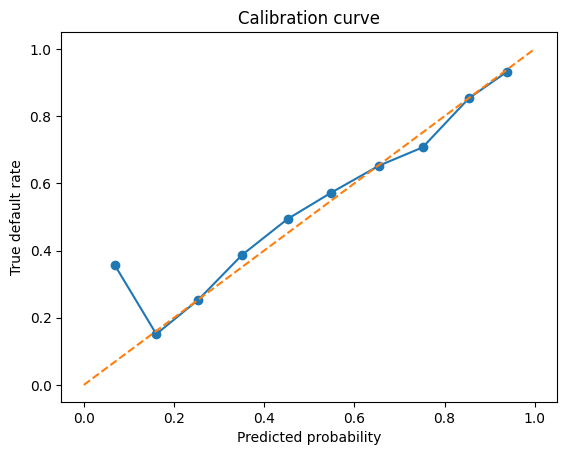

0.3446858778258172
[ 0.288742   -0.00940398 -0.0003073   0.03597721  0.04196667  0.02369816
 -0.00189503 -0.04434102 -0.00081147 -0.00647032]


In [ ]:
# 2. Train / Test split
TRAIN_END = pd.to_datetime("2024-06-30")
df_loaded["application_date"]=pd.to_datetime(df_loaded["application_date"])

train = df_loaded[df_loaded["application_date"] <= TRAIN_END]
test  = df_loaded[df_loaded["application_date"] > TRAIN_END]

X_train = train.drop(columns=["default_12m","application_date"])
y_train = train["default_12m"]
X_test = test.drop(columns=["default_12m","application_date"])
y_test = test["default_12m"]

# 3. Логистическая регрессия
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

# 4. Предсказания и метрики
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)  # cut-off = 0.5

print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Brier score:", brier_score_loss(y_test, y_pred_proba))
print("Confusion matrix (cut-off=0.5):\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 5. Reliability curve (калибровка)
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Predicted probability")
plt.ylabel("True default rate")
plt.title("Calibration curve")
plt.show()

mhk_err=np.sqrt((y_test-y_pred_proba)**2)
print(np.mean(mhk_err))
print(prob_true-prob_pred)

[LightGBM] [Info] Number of positive: 10534, number of negative: 6113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3337
[LightGBM] [Info] Number of data points in the train set: 16647, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.632787 -> initscore=0.544190
[LightGBM] [Info] Start training from score 0.544190
LightGBM ROC AUC (без калибровки): 0.81609679883608
LightGBM Brier score (без калибровки): 0.17451967586713954
[LightGBM] [Info] Number of positive: 10534, number of negative: 6113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3337
[Lig

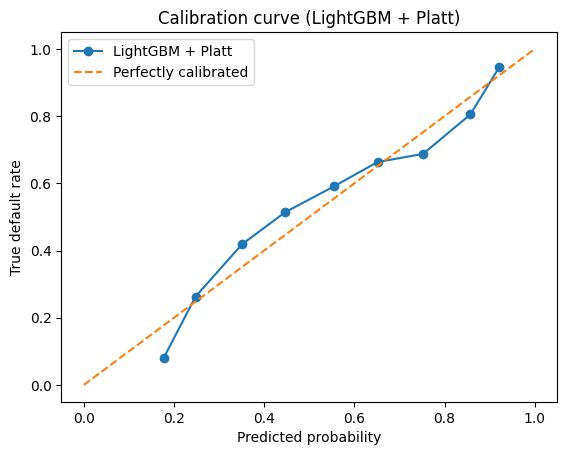

In [ ]:
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# 1. Обучаем LightGBM (без калибровки)
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'scale_pos_weight': (y_train.value_counts()[0] / y_train.value_counts()[1])  # балансировка классов
}
lgb_model = lgb.train(params, train_data, num_boost_round=200)

# Предсказания без калибровки
y_pred_proba_lgb = lgb_model.predict(X_test)

print("LightGBM ROC AUC (без калибровки):", roc_auc_score(y_test, y_pred_proba_lgb))
print("LightGBM Brier score (без калибровки):", brier_score_loss(y_test, y_pred_proba_lgb))

# 2. Platt scaling (калибровка вероятностей)
from sklearn.ensemble import GradientBoostingClassifier

# LightGBM в sklearn-обёртке для калибровки
lgb_sklearn = lgb.LGBMClassifier(**params, n_estimators=200)
lgb_sklearn.fit(X_train, y_train)

calibrated_model = CalibratedClassifierCV(lgb_sklearn, method='sigmoid', cv=3)  # Platt scaling
calibrated_model.fit(X_train, y_train)

y_pred_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]

print("LightGBM ROC AUC (с Platt calibration):", roc_auc_score(y_test, y_pred_proba_cal))
print("LightGBM Brier score (с Platt calibration):", brier_score_loss(y_test, y_pred_proba_cal))

calibrated_iso = CalibratedClassifierCV(lgb_sklearn, method='isotonic', cv=3)
calibrated_iso.fit(X_train, y_train)
y_pred_proba_iso = calibrated_iso.predict_proba(X_test)[:, 1]

print("AUC (Isotonic):", roc_auc_score(y_test, y_pred_proba_iso))
print("Brier (Isotonic):", brier_score_loss(y_test, y_pred_proba_iso))


# 3. Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba_cal, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="LightGBM + Platt")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("True default rate")
plt.legend()
plt.title("Calibration curve (LightGBM + Platt)")
plt.show()

# градиентный спуск добавить, улучшить PD модель. ROC=>0.9 WOE или калибровку поменять. В Гит залить